### Name: Shaishav Shah
### Amsterdam Airbnb Exploratory Analysis and Predictive Model

### Required Libraries 

In [1]:
# Preprocessing and Visualisation 
import pandas as pd
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
from sklearn import preprocessing

# Predictive Modelling
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split # train-test data split
from sklearn.linear_model import LinearRegression # linear regression

#Accuracy Estimators
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.metrics import r2_score

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

### About Dataset
<b>Source</b>: http://insideairbnb.com/get-the-data.html
<br><b>Data</b>: Amsterdam, North Holland, The Netherlands (Detailed Listings data for Amsterdam)
<br> <b>Why this Dataset</b>: Because it was the most recent dataset available

In [2]:
# Data loading
airbnb  = pd.read_csv("listings.csv")

In [3]:
# Total number of columns and observations in dataset
airbnb.shape

(20677, 106)

There are 20677 observations and 106 columns in the data set (Amsterdam and Neighbourhood)

### Data Cleaning

1. Out of all the 106 columns, not all columns are important and required. Dropping unwanted columns like listing_url, scrape_id, last_scraped, thumbnail_url, medium_url, picture_url, xl_picture_url, etc
2. City column was also dropped as the data contains details only from Amsterdam, North Holland, The Netherlands

In [4]:
airbnb = airbnb.drop(["listing_url","scrape_id",'last_scraped','thumbnail_url','medium_url','picture_url','xl_picture_url',
                    'host_url','host_thumbnail_url','host_picture_url','host_has_profile_pic','city','calendar_last_scraped',
                    'calendar_updated','notes','neighbourhood_group_cleansed','square_feet','weekly_price',
                    'monthly_price','license','host_about'], axis=1)

There are 886 records with no zipcodes. Also, with some research, it was found that there are only 81 zipcodes in Amsterdam. We compared the zipcodes and removed all the Null values and other city zipcodes since we are only focusing on Amsterdam. 

In [5]:
print(airbnb["zipcode"].isnull().sum())
airbnb = airbnb.dropna(subset=['zipcode'])

886


In [6]:
amsterdam_zipcode = ["1011", "1012", "1013", "1014", "1015", "1016", "1017", "1018", "1019", "1021", "1022", "1023", "1024", "1025", "1026", "1027", "1028", 
                     "1031", "1032", "1033", "1034", "1035", "1036", "1037", "1041", "1042", "1043", "1044", "1045", "1046", "1047", "1051", "1052", "1053",
                     "1054", "1055", "1056", "1057", "1058", "1059", "1060", "1061", "1062", "1063", "1064", "1065", "1066", "1067", "1068", "1069", "1071",
                     "1072", "1073", "1074", "1075", "1076", "1077", "1078", "1079", "1081", "1082", "1083", "1086", "1087", "1091", "1092", "1093", "1094",
                     "1095", "1096", "1097", "1098", "1101", "1102", "1103", "1104", "1105", "1106", "1107", "1108", "1109"]

In [7]:
airbnb["clean_zipcode"] = airbnb["zipcode"].str.slice(0, 4)
airbnb = airbnb[airbnb['clean_zipcode'].isin(amsterdam_zipcode)]

### Missing Values

The data set have many null values. To preserve all the information, we imputed or dropped the rows and columns containing null values while conducting exploratory analysis that made use of these features.

In [8]:
airbnb.isnull().sum()

id                                                 0
name                                              31
summary                                          607
space                                           5070
description                                      210
                                                ... 
calculated_host_listings_count_entire_homes        0
calculated_host_listings_count_private_rooms       0
calculated_host_listings_count_shared_rooms        0
reviews_per_month                               2405
clean_zipcode                                      0
Length: 86, dtype: int64

1. Out of all the columns with missing values, beds and bedroom are the most important. If ‘beds’ has a missing value, and ‘bedrooms’ has a valid value, ‘beds’ can be set with the value of ‘bedrooms’.If ‘bedrooms’ has a missing value, we will assign it 1 as there will be one room atleast. If both ‘bedrooms’ and ‘beds’ are missing, both fields are set to 1, which is the average number of beds and bedrooms.
2. Number of reviews per month feature has some missing data. For this feature, missing data will be replaced with mean. Since the data is more symmetric, mean replacement would be better.
3. Assuming that there will be atleast one bathroom in each rental property, we replace missingvalues in bathroom with 1. 

In [9]:
airbnb.loc[(airbnb["beds"].isnull()== True) & (airbnb["bedrooms"].isnull()== False), ['beds','bedrooms']] = airbnb["bedrooms"]
airbnb.loc[(airbnb["beds"].isnull()== True) & (airbnb["bedrooms"].isnull()== True), ['beds','bedrooms']] = 1
airbnb.loc[(airbnb["bedrooms"].isnull()== True), ['bedrooms']] = 1
airbnb.loc[(airbnb["bathrooms"].isnull()== True), ['bathrooms']] = 1
airbnb['reviews_per_month'].fillna(airbnb['reviews_per_month'].mean(), inplace=True)

### Quick Glance on the Data set

1. There are 19,738 unique listing in Amsterdam in total with 17,045 unique host. The first rental in Amsterdam was up in October, 2008 in Amsterdam, North Holland.
2. Over 466,000 million reviews have been written by guests since then.
3. The price for a listing ranges from 9.00 USD per night to 8,915 USD per night. Out of this only 25 rental properties have price per night greater than 1000 USD 
4. On a average, cost of a rental for a night is approximately 158 USD

In [10]:
len(airbnb.host_id.unique())

17045

In [11]:
airbnb[['host_since','host_location']].sort_values(by = 'host_since').head(1)

,host_since,host_location
20619,2008-10-12,"Amsterdam, North Holland, Netherlands"


In [12]:
airbnb.number_of_reviews.sum()

466723

In [13]:
def clean_currency(x):
    if isinstance(x, str):
        return(x.replace('$', '').replace(',', ''))
    return(x)

airbnb = airbnb[airbnb.price > '$0.00']
airbnb['price'] = airbnb['price'].apply(clean_currency).astype('float')

In [14]:
print("$",airbnb['price'].max())
print("$",airbnb['price'].min())

$ 8915.0
$ 9.0


In [15]:
print(len(airbnb[airbnb["price"]>1000.0]))

25


In [16]:
average_price_per_night = round(airbnb["price"].mean(),2)
print("$",average_price_per_night)

$ 157.98


### Exploring the Data set:

1. Find the top 10 host in Amsterdam with maximum rental properties with Airbnb

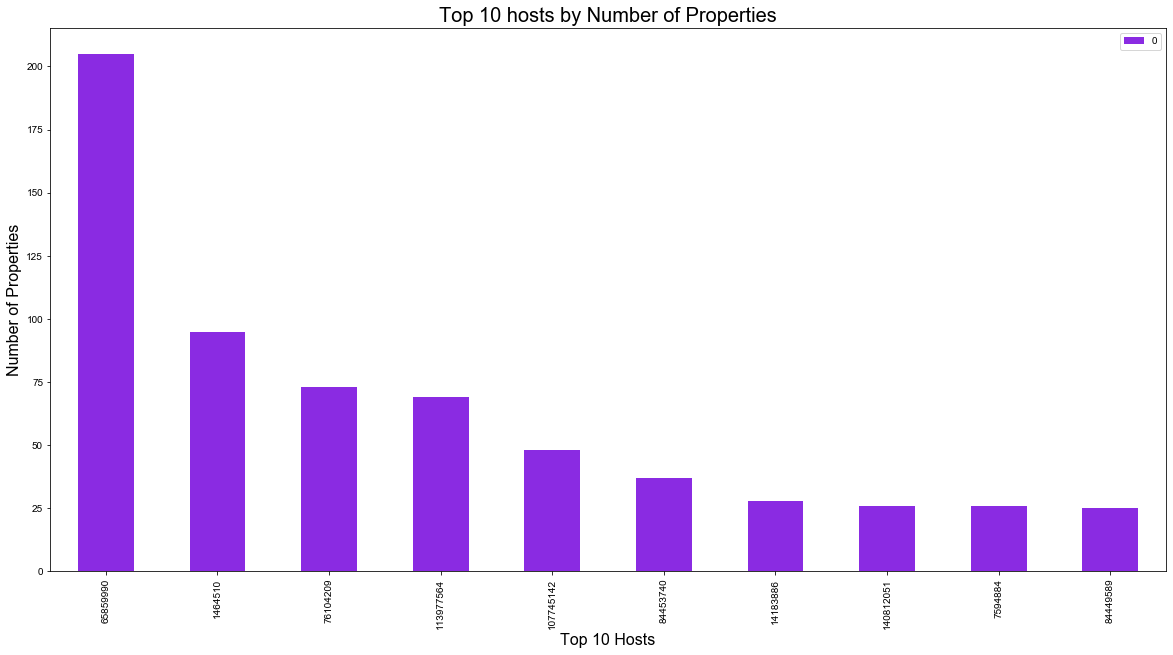

In [17]:
top_host_df = airbnb.groupby('host_id').host_id.count()
top_host_df = top_host_df.rename(columns={"host_id": 'abc'})
top_host_df = top_host_df.reset_index()
top_host_df = (top_host_df.sort_values(by=0, ascending =False)).head(10)
top_host_df.plot.bar(x='host_id', y=0,figsize=(20,10), color='blueviolet')
plt.title('Top 10 hosts by Number of Properties', fontsize=20)
plt.style.use('seaborn-dark')
plt.ylabel('Number of Properties', fontsize=16)
plt.xlabel('Top 10 Hosts', fontsize=16)
plt.grid(False)
plt.show()

2. Fining the distribution of room type in Amsterdam

In [18]:
room_type_df = airbnb.groupby('room_type').id.count()
room_type_df = room_type_df.reset_index()
room_type_df = room_type_df.rename(columns={'id': 'number_of_listings'})
room_type_df["percentage"] = round((room_type_df["number_of_listings"]/room_type_df.number_of_listings.sum())*100,2)
room_type_df

,room_type,number_of_listings,percentage
0,Entire home/apt,15650,79.29
1,Private room,4012,20.33
2,Shared room,75,0.38


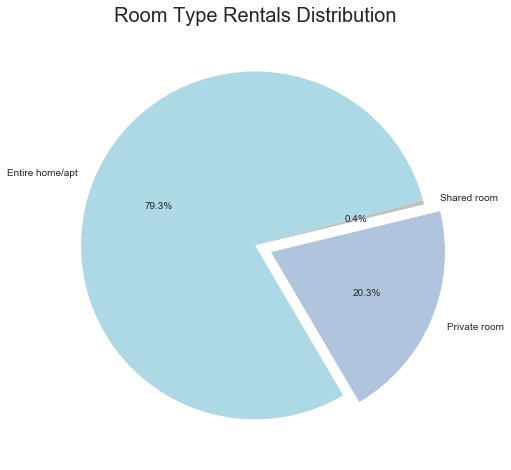

In [19]:
# Room Type Rentals Distribution
number_of_listings = [room_type_df.number_of_listings]
room_type = room_type_df.room_type
plt.figure(figsize=(8,8))
plt.style.use('seaborn-dark')
plt.pie(number_of_listings,labels=room_type,autopct='%1.1f%%',startangle=15, explode=(0, 0.1, 0), colors = ['lightblue','lightsteelblue','silver'])
plt.title('Room Type Rentals Distribution', fontsize=20)
plt.show()

<b>Conclusion</b>: Most of the properties available for rental in Amsterdam are Entire home or Apartment

3. Fining the distribution of property type in Amsterdam

In [20]:
property_type_df = airbnb.groupby('property_type').id.count()
property_type_df = property_type_df.reset_index()
property_type_df = property_type_df.rename(columns={'id': 'number_of_listings'})
property_type_df = property_type_df.sort_values(by= 'number_of_listings', ascending = True).tail(10)
property_type_df["percentage"] = round((property_type_df["number_of_listings"]/room_type_df.number_of_listings.sum())*100,2)
property_type_df

,property_type,number_of_listings,percentage
29,Serviced apartment,68,0.34
17,Guest suite,142,0.72
22,Houseboat,271,1.37
13,Condominium,322,1.63
4,Boat,329,1.67
26,Loft,382,1.94
3,Bed and breakfast,536,2.72
32,Townhouse,648,3.28
21,House,1579,8.00
1,Apartment,15200,77.01


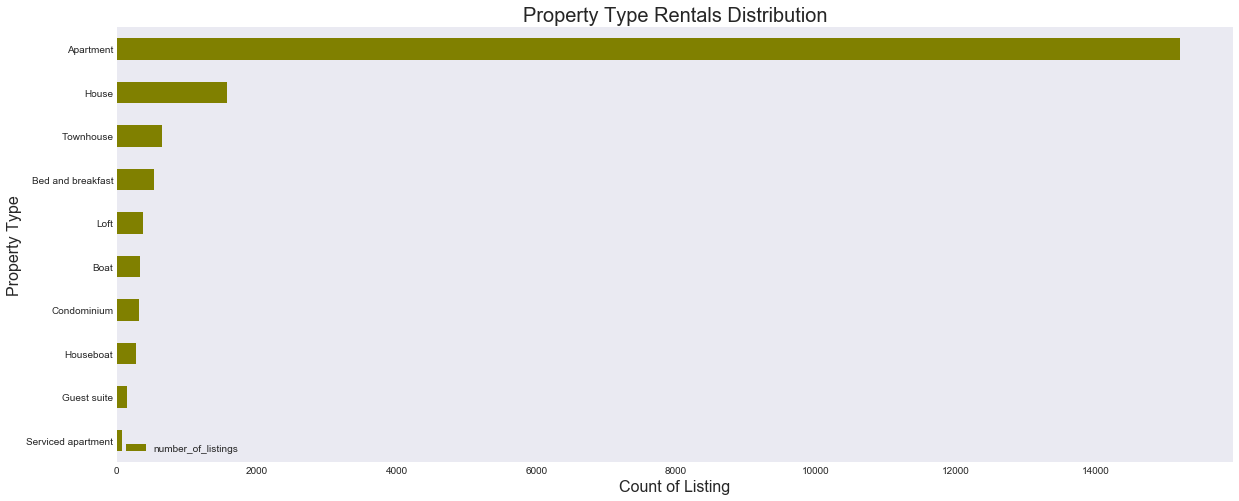

In [21]:
# Property Type Rentals Distribution
property_type_df.plot.barh(x='property_type', y='number_of_listings',figsize=(20,8), color = "olive" )
plt.style.use('seaborn-dark')
plt.title('Property Type Rentals Distribution', fontsize=20)
plt.ylabel('Property Type', fontsize=16)
plt.xlabel('Count of Listing', fontsize=16)
plt.grid(False)
plt.show()

4. HeatMap for price variations with Room Type and Top 10 Property types

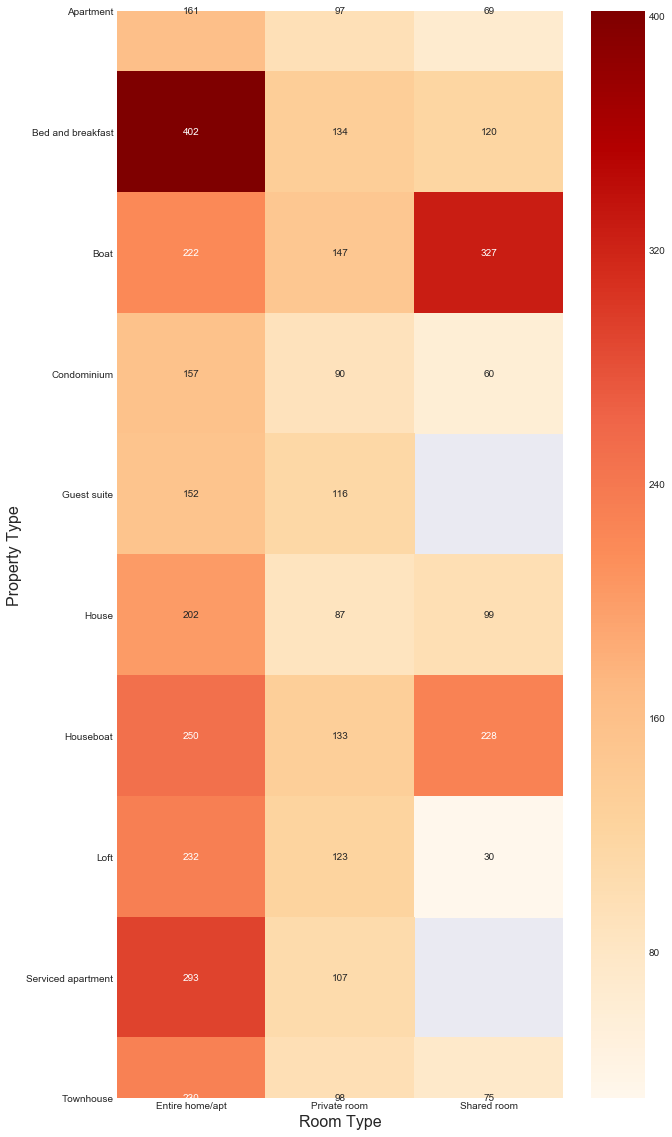

In [22]:
heatmap_df = airbnb.groupby(['property_type', 'room_type']).price.mean().unstack()
heatmap_df = heatmap_df[heatmap_df.index.isin(property_type_df.property_type)]

plt.figure(figsize=(10, 20))
plt.style.use('seaborn-dark')
sns.heatmap(heatmap_df, annot=True, fmt='.0f', cmap ='OrRd')
plt.ylabel('Property Type', fontsize=16)
plt.xlabel('Room Type', fontsize=16)
plt.yticks(rotation=0)
plt.show()

5. HeatMap for price variations with Bedroom Types and Neighbourhood

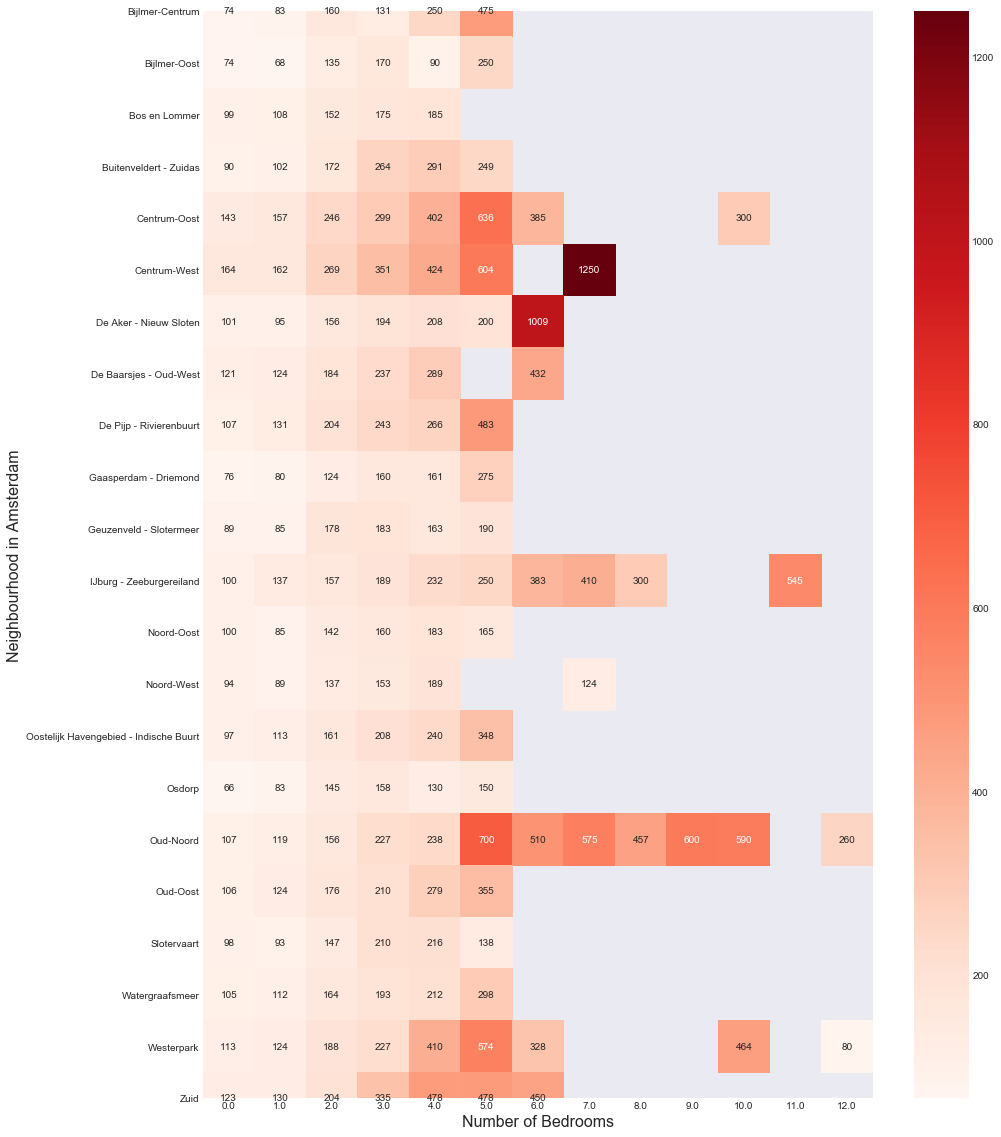

In [23]:
plt.figure(figsize=(15, 20))
plt.style.use('seaborn-dark')
sns.heatmap(airbnb.groupby(['neighbourhood_cleansed', 'bedrooms']).price.mean().unstack(), annot=True, fmt=".0f", cmap = "Reds")
plt.ylabel('Neighbourhood in Amsterdam', fontsize=16)
plt.xlabel('Number of Bedrooms', fontsize=16)
plt.show()

6. Distribution of Airbnb rental prices in Amsterdam

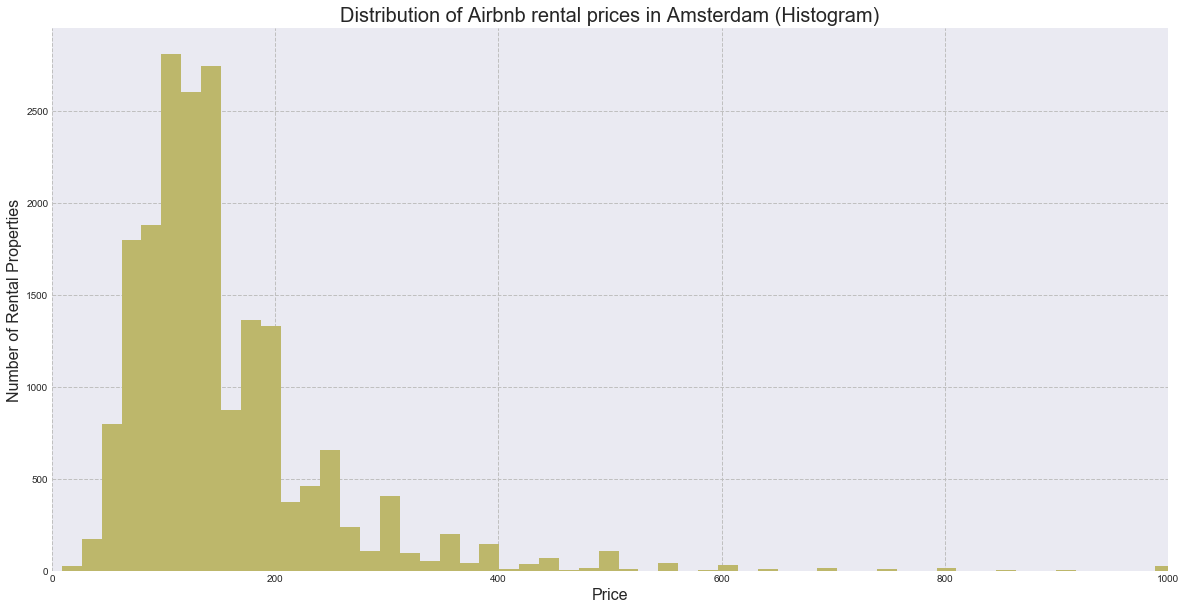

In [24]:
airbnb.hist(column='price', bins=500, grid=True, figsize=(20,10), color = 'darkkhaki')
plt.style.use('seaborn-dark')
plt.title('Distribution of Airbnb rental prices in Amsterdam (Histogram)', fontsize=20)
plt.ylabel('Number of Rental Properties', fontsize=16)
plt.xlabel('Price', fontsize=16)
plt.xlim(0,1000)
plt.grid(color='silver', linestyle='--', linewidth=1)
plt.show()

The above distribution graph shows that there is a right-skewed distribution on price. This means there is a positive skewness. Log transformation will be used to make this feature less skewed. This will help to make easier interpretation and better statistical analysis

With help of log transformation, now, price feature have normal distribution.

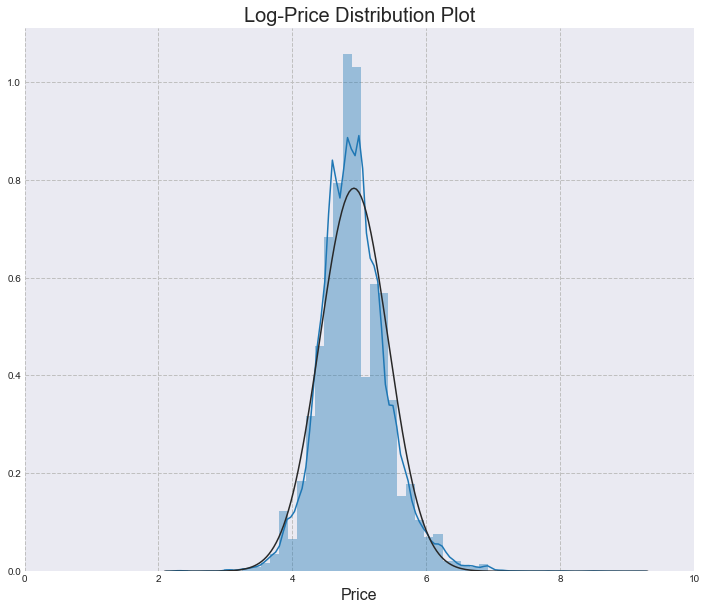

In [25]:
airbnb['price_log'] = np.log(airbnb.price+1)
plt.style.use('seaborn-dark')
plt.figure(figsize=(12,10))
sns.distplot(airbnb['price_log'], fit=norm)
plt.title("Log-Price Distribution Plot", fontsize=20)
plt.xlabel('Price', fontsize=16)
plt.xlim(0,10)
plt.grid(color='silver', linestyle='--', linewidth=1)
plt.show()

In below graph, the good fit indicates that normality is a reasonable approximation.

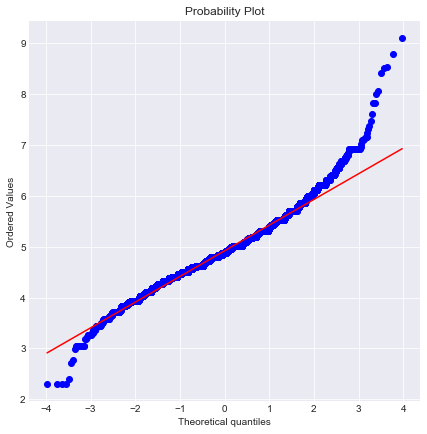

In [26]:
plt.style.use('seaborn-dark')
plt.figure(figsize=(7,7))
stats.probplot(airbnb['price_log'], plot=plt)
plt.grid(True)
plt.show()

Distribution of Airbnb rental prices in Amsterdam (Boxplot)

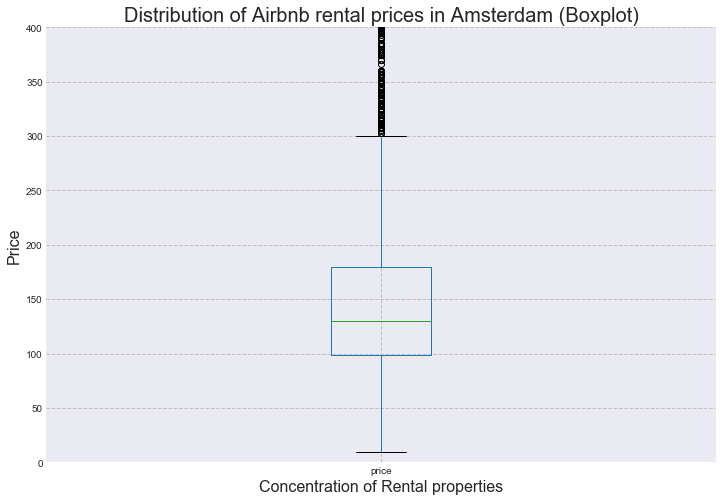

In [27]:
airbnb.boxplot(column='price', grid=True, figsize=(12,8))
plt.style.use('seaborn-dark')
plt.title('Distribution of Airbnb rental prices in Amsterdam (Boxplot)', fontsize=20)
plt.ylabel('Price', fontsize=16)
plt.xlabel('Concentration of Rental properties', fontsize=16)
plt.ylim(0,400)
plt.grid(color='silver', linestyle='--', linewidth=1)
plt.show()

<b> Conclusion </b>: Most properties are available in the range of 100 USD to 180 USD per night with an average of approximately 140 USD

7. Neighbourhood Avergae Price Distribution below 500 USD

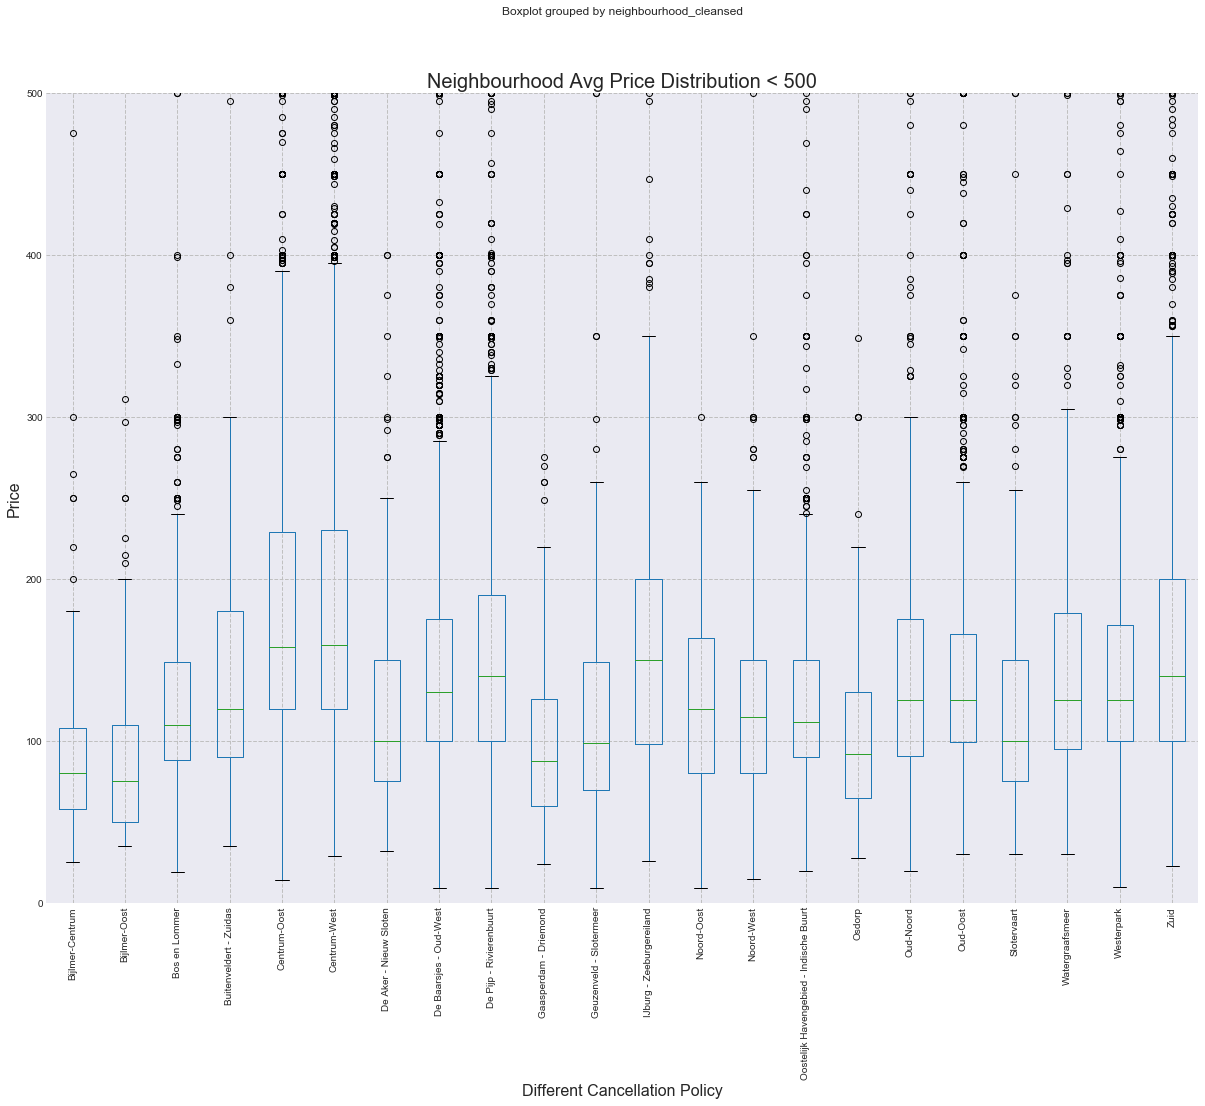

In [28]:
airbnb.boxplot(column='price', by="neighbourhood_cleansed", grid=True, figsize=(20,15))
plt.style.use('seaborn-dark')
plt.title('Neighbourhood Avg Price Distribution < 500', fontsize=20)
plt.ylabel('Price', fontsize=16)
plt.xlabel('Different Cancellation Policy', fontsize=16)
plt.xticks(rotation=90)
plt.ylim(0,500)
plt.grid(color='silver', linestyle='--', linewidth=1)
plt.show()

<b>Conclusion</b>: Centrum-Oost and Centrum-West has the most expensive accomodation followed by Zuid and IJburg - Zeeburgereiland. Least expensive accomdations are available in Bijlmer-Oost followed by Gaasperdam - Driemond 

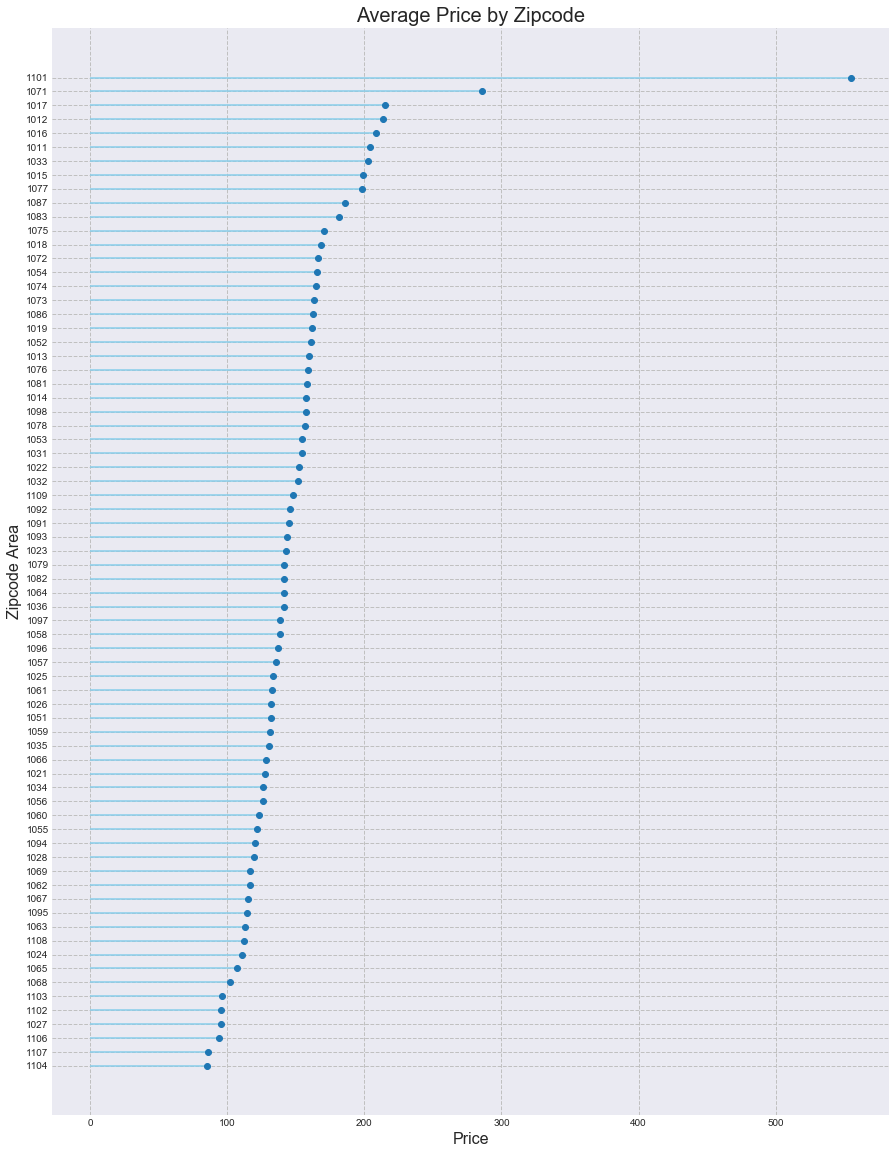

In [29]:
zipcode_df = airbnb.groupby("clean_zipcode").price.mean()
zipcode_df = zipcode_df.reset_index()
zipcode_df = zipcode_df.rename(columns={'clean_zipcode': 'Zipcode Area'})
zipcode_df["price"] = round(zipcode_df["price"],2)
zipcode_df = zipcode_df.sort_values( by="price")

plt.figure(figsize=(15, 20))
plt.style.use('seaborn-dark')
plt.hlines(y= zipcode_df['Zipcode Area'], xmin=0, xmax=zipcode_df['price'], color='skyblue')
plt.plot(zipcode_df['price'], zipcode_df['Zipcode Area'], "o")
plt.title('Average Price by Zipcode', fontsize=20)
plt.xlabel('Price', fontsize=16)
plt.ylabel('Zipcode Area', fontsize=16)
plt.grid(color='silver', linestyle='--', linewidth=1)
plt.show()

<b>Conclusion</b>: Most expensive accomodation is avaliable in 1101 Zipcode

8. Most Common Amenities Available in Rental Properties

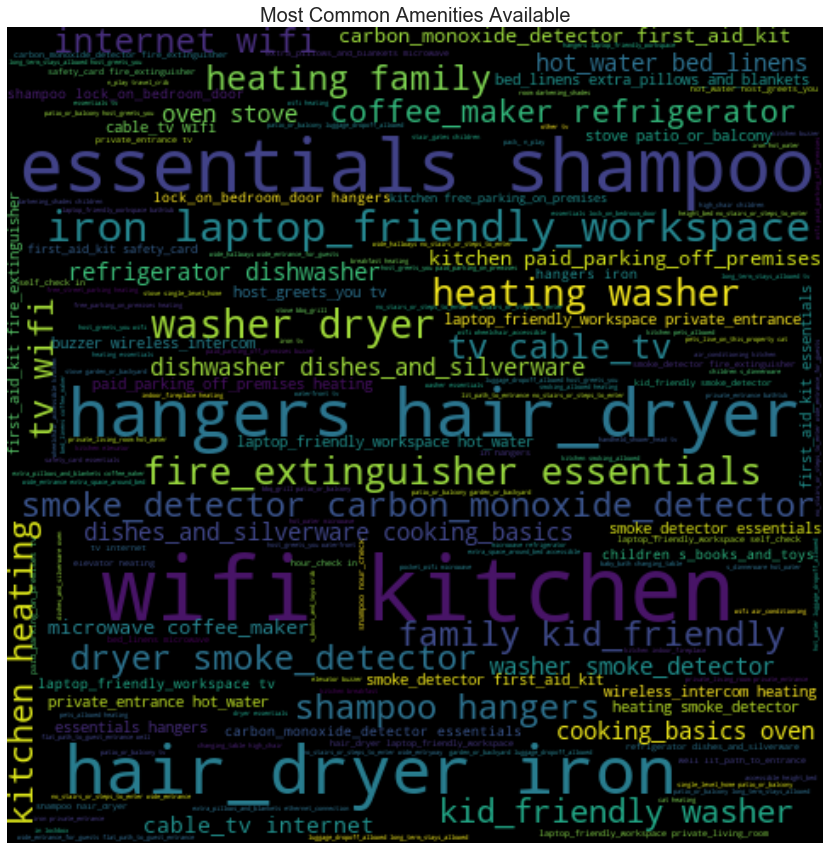

In [30]:
words_list = list()
words_clean = list()
for line in airbnb.amenities:
    words_list.append(line.split(","))

for words in words_list:
    for word in words:
        word = word.strip()
        word = word.replace("{", "")
        word = word.replace("}", "")
        word = word.replace('"', "")
        word = word.lower()
        word = word.replace(" ","_")
        if word.startswith('translation'):
            continue
        words_clean.append(word)
    
how_to_join = " "
words_clean_str = how_to_join.join(words_clean)

# Create the wordcloud object
wordcloud = WordCloud(width=480, height=480, margin=0).generate(words_clean_str)
 
# Display the generated image:
plt.figure(figsize=(15, 15))
plt.style.use('seaborn-dark')
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Most Common Amenities Available', fontsize=20)
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

<b>Conclusion</b>: Most common amenities available are Hair Dryer, Iron, Hangers, Essentials, Shampoo, Wifi and Internet. It is important to note that free parking is not available very commonly. Hence, use public transportation instead of renting a vehicle when in Amsterdam to save some money.

### Price Prediction Model (Linear Regression)

1. Creating a DataFrame with only important columns as per the analysis
2. Factorizing Categorical variables for linear regression and finding correlation between variables

In [31]:
price_df = airbnb[["price_log","cancellation_policy","bedrooms","bed_type","property_type",
                   "availability_30","number_of_reviews","room_type", "reviews_per_month","neighbourhood" ]]
price_df["cancellation_policy"] = price_df["cancellation_policy"].factorize()[0]
price_df["property_type"] = price_df["property_type"].factorize()[0]
price_df["room_type"] = price_df["room_type"].factorize()[0]
price_df["neighbourhood"] = price_df["neighbourhood"].factorize()[0]
price_df["bed_type"] = price_df["bed_type"].factorize()[0]

Visualising correlation matrix of dependent variables with price

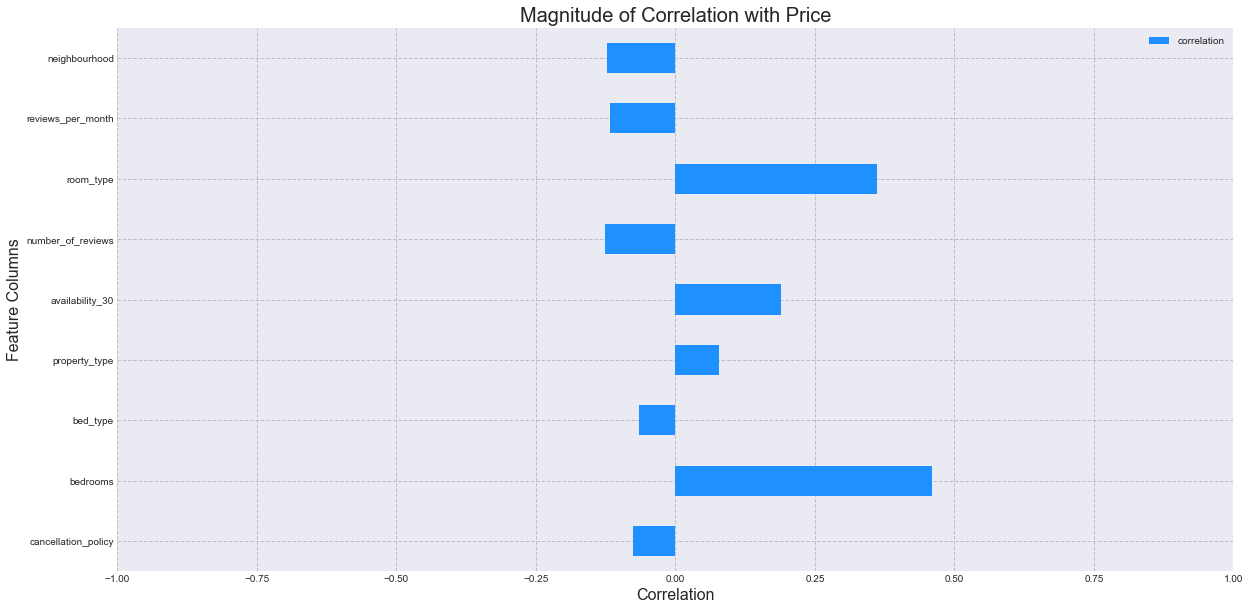

In [32]:
corrMatrix_price = pd.DataFrame(price_df.corrwith(price_df.price_log))
corrMatrix_price = corrMatrix_price.reset_index()
corrMatrix_price = corrMatrix_price.rename(columns={'index': 'feature_columns',0:'correlation'})
corrMatrix_price = corrMatrix_price[corrMatrix_price.feature_columns != "price_log"]
corrMatrix_price.plot.barh(x='feature_columns', y='correlation',figsize=(20,10), color = 'dodgerblue' )
plt.title('Magnitude of Correlation with Price', fontsize=20)
plt.ylabel('Feature Columns', fontsize=16)
plt.xlabel('Correlation', fontsize=16)
plt.xlim(-1.0,1.0)
plt.grid(color='silver', linestyle='--', linewidth=1)
plt.show()

<b>Conclusion</b>: Bedrooms and Room Types are highly correlated with price with kind of make sense. More the number of bedrooms, more the price. Also, entire house are more costly than private or shared room.

Creating dependent variable DataFrame and independent variable DataFrame for heatmap and prediction

In [34]:
X = price_df.drop(["price_log"], axis=1)
y = price_df.price_log

The correlation table shows that there is no strong relationship between price and other features. This indicates no feature needed to be taken out of data. 

Text(0.5, 1, 'Correlation Matrix')

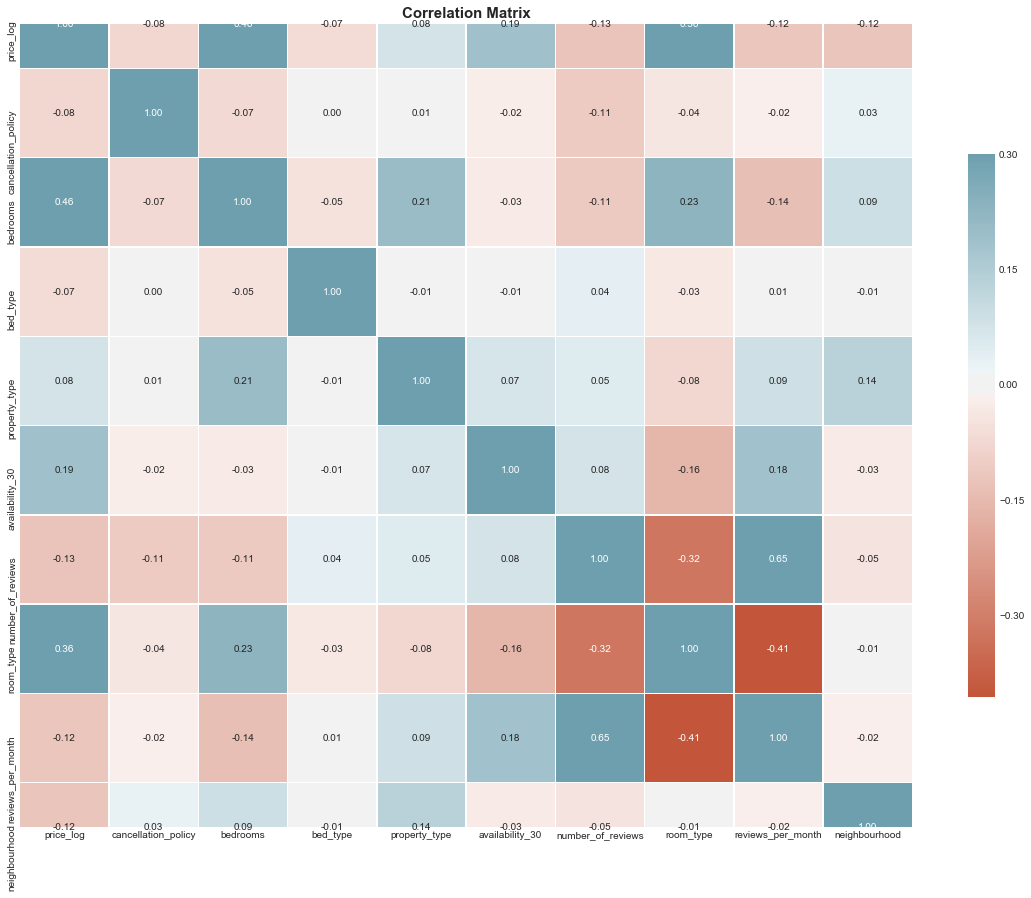

In [35]:
plt.figure(figsize=(20,20))
palette = sns.diverging_palette(20, 220, n=256)
corr=price_df.corr(method='pearson')
sns.heatmap(corr, annot=True, fmt=".2f", cmap=palette, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Correlation Matrix",size=15, weight='bold')  

Multicollinearity will help to measure the relationship between explanatory variables in multiple regression. If there is multicollinearity occurs, these highly related input variables should be eliminated from the model.

In this kernel, multicollinearity will be control with Eigen vector values results.

In [36]:
#Eigen vector of a correlation matrix.
multicollinearity, V=np.linalg.eig(corr)
multicollinearity

array([2.21111701, 1.53082281, 0.3278434 , 0.40338   , 0.61993301,
       1.19411262, 0.79665591, 0.89611077, 1.03092945, 0.98909502])

None one of the eigenvalues of the correlation matrix is close to zero. It means that there is no multicollinearity exists in the data.

Standard Scaler technique will be used to normalize the data set.

In [37]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

Test and Train Dataset for prediction

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42)

Feature Selection and their importance

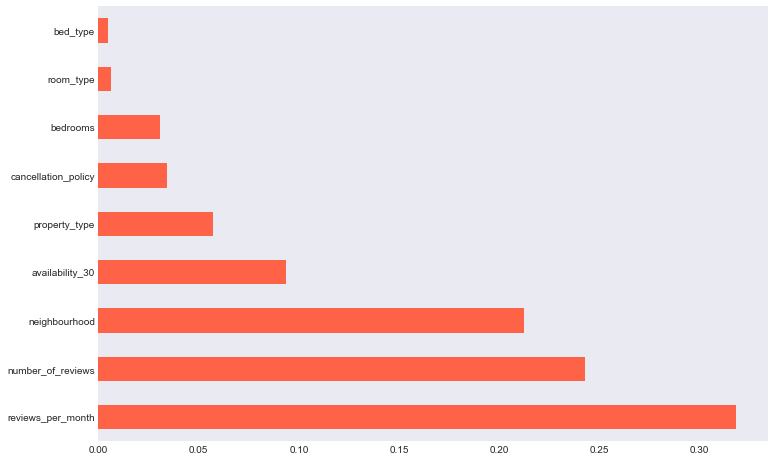

In [39]:
lab_enc = preprocessing.LabelEncoder()

feature_model = ExtraTreesClassifier(n_estimators=50)
feature_model.fit(X_train,lab_enc.fit_transform(y_train))

plt.figure(figsize=(12,8))
feat_importances = pd.Series(feature_model.feature_importances_, index=(price_df.drop(["price_log"], axis=1)).columns)
feat_importances.nlargest(10).plot(kind='barh', color="tomato")
plt.show()

<b>Conclusion</b>: Bed Type and Room Type have lowest importance and can be removed to see if accuracy improves. 

Linear Regression without feature selection

In [40]:
lr = LinearRegression(copy_X= True, fit_intercept = True, normalize = True)
lr.fit(X_train, y_train)
lr_pred= lr.predict(X_test)
print('--Linear Regression without feature selection--')
print('MAE: %f'% mean_absolute_error(y_test, lr_pred))
print('RMSE: %f'% np.sqrt(mean_squared_error(y_test, lr_pred)))   
print('R2: %f' % r2_score(y_test, lr_pred))

--Linear Regression without feature selection--
MAE: 0.302644
RMSE: 0.407691
R2: 0.357544


Dropping lowest important features for prediction

In [41]:
X_f = price_df.drop(["price_log","bed_type","room_type"], axis=1)
y_f = price_df.price_log

Standard Scaler technique will be used to normalize the data set.

In [42]:
scaler = StandardScaler()
X_f = scaler.fit_transform(X_f)

Test and Train Dataset for prediction

In [43]:
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_f, y_f, test_size=0.25,random_state=42)

Linear Regression without feature selection

In [44]:
lr = LinearRegression(copy_X= True, fit_intercept = True, normalize = True)
lr.fit(X_train_f, y_train_f)
lr_pred_f= lr.predict(X_test_f)
print('--Linear Regression without feature selection--')
print('MAE: %f'% mean_absolute_error(y_test_f, lr_pred_f))
print('RMSE: %f'% np.sqrt(mean_squared_error(y_test_f, lr_pred_f)))   
print('R2 %f' % r2_score(y_test_f, lr_pred_f))

--Linear Regression without feature selection--
MAE: 0.322980
RMSE: 0.431986
R2 0.278693


Visualizing Linear Regression Model Predictions

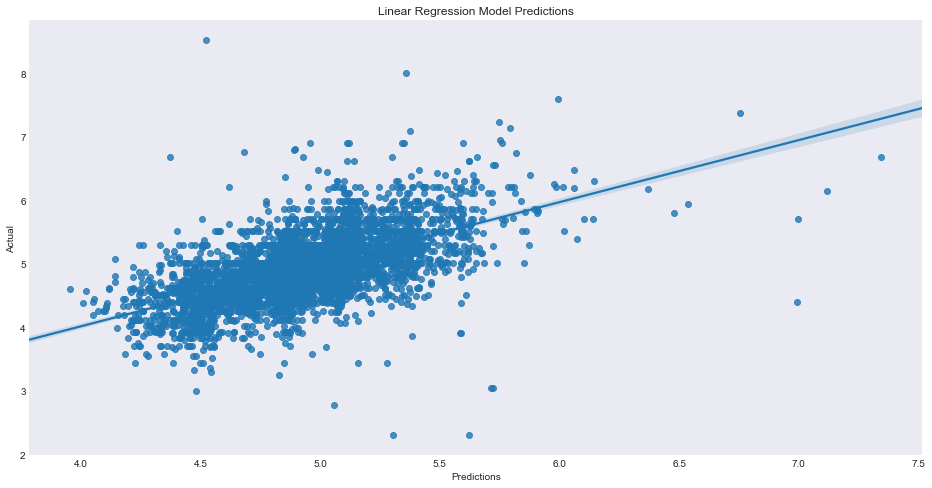

In [45]:
plt.figure(figsize=(16,8))
sns.regplot(lr_pred,y_test)
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.title("Linear Regression Model Predictions")
plt.show()